# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [2]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [3]:
versioninfo()

Julia Version 1.11.5
Commit 760b2e5b739 (2025-04-14 06:53 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, broadwell)
Threads: 2 default, 0 interactive, 1 GC (on 2 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = auto


# Horse Race Portfolio Optimization

**Runners:** Redeeming Vices (1), Gwendolyn (2), Ernest (3)

**Odds (net return per $1 bet):** `1, 2, 4` → **net payoff if wins**

**True probabilities:** `0.6, 0.3, 0.1`

We solve **all 6 parts** using **Julia**.


In [9]:
import Pkg
Pkg.add.(["JuMP", "Ipopt", "GLPK", "Statistics", "Plots", "DataFrames"])
using JuMP, Ipopt, GLPK, LinearAlgebra, Statistics, Plots, Printf, DataFrames


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed StructTypes ──────── v1.11.0
   Installed JSON3 ────────────── v1.14.3
   Installed CodecBzip2 ───────── v0.8.5
   Installed BenchmarkTools ───── v1.6.3
   Installed MutableArithmetics ─ v1.6.7
   Installed MathOptInterface ─── v1.46.0
   Installed JuMP ─────────────── v1.29.2
    Updating `~/.julia/environments/v1.11/Project.toml`
  [4076af6c] + JuMP v1.29.2
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.6.3
  [523fee87] + CodecBzip2 v0.8.5
  [0f8b85d8] + JSON3 v1.14.3
  [4076af6c] + JuMP v1.29.2
  [b8f27783] + MathOptInterface v1.46.0
  [d8a4904e] + MutableArithmetics v1.6.7
  [856f2bd8] + StructTypes v1.11.0
  [9abbd945] + Profile v1.11.0
Precompiling project...
   5620.1 ms  ✓ CodecBzip2
   6415.1 ms  ✓ StructTypes
   4468.6 ms  ✓ BenchmarkTools
  17400.9 ms  ✓ MutableArithmetics
  21229.2 ms  ✓ JSON3
  84877.5 ms  ✓ MathOptInterface
 

## 1. Optimal Growth (Kelly Criterion)

Maximize expected log-wealth:

$$ \max_w \sum_{i=1}^3 p_i \log(1 + w_i \cdot o_i) $$

s.t. $\sum w_i = 1$, $w_i \geq 0$

In [10]:
odds = [1.0, 2.0, 4.0]
p = [0.6, 0.3, 0.1]

model = Model(Ipopt.Optimizer)
set_silent(model)

@variable(model, w[1:3] >= 0)
@constraint(model, sum(w) == 1)
@NLobjective(model, Max, sum(p[i] * log(1 + w[i] * odds[i]) for i in 1:3))

optimize!(model)

w_kelly = value.(w)

println("1. Kelly Optimal Weights: ", round.(w_kelly, digits=4))

expected_growth = sum(p[i] * log(1 + w_kelly[i] * odds[i]) for i in 1:3)
println("   Expected log-growth: ", round(expected_growth, digits=4))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

1. Kelly Optimal Weights: [0.65, 0.325, 0.025]
   Expected log-growth: 0.4602


## 2. Expected Return of Each Pure Bet

For bet $i$:

$$ E[R_i] = p_i \cdot o_i + (1 - p_i) \cdot (-1) = p_i (o_i + 1) - 1 $$

In [12]:
E_R = p .* (odds .+ 1) .- 1

println("2. Expected Returns:")
for i in 1:3
    @printf "   Runner %d: %.3f\n" i E_R[i]
end

2. Expected Returns:
   Runner 1: 0.200
   Runner 2: -0.100
   Runner 3: -0.500


## 3. Variance-Covariance Matrix

Since **only one horse wins**, outcomes are **mutually exclusive**.

Let $R_i$ = return of bet on horse $i$:
- $R_i = o_i$ if $i$ wins
- $R_i = -1$ otherwise

Mean: $\mu_i = E[R_i]$

**Variance:**
$$ \text{Var}(R_i) = p_i (o_i - \mu_i)^2 + (1-p_i) (-1 - \mu_i)^2 $$

**Covariance $(i \neq j)$:**
$$ \text{Cov}(R_i, R_j) = p_i (o_i - \mu_i)(-1 - \mu_j) + p_j (-1 - \mu_i)(o_j - \mu_j) $$

In [13]:
# Precompute μ
μ = E_R

Σ = zeros(3,3)

for i in 1:3
    # Variance
    Σ[i,i] = p[i] * (odds[i] - μ[i])^2 + (1 - p[i]) * (-1 - μ[i])^2
end

for i in 1:3, j in 1:3
    if i != j
        # Covariance
        Σ[i,j] = p[i]*(odds[i]-μ[i])*(-1-μ[j]) + p[j]*(-1-μ[i])*(odds[j]-μ[j])
    end
end

println("3. Variance-Covariance Matrix:")
display(round.(Σ, digits=2))

println("   Variances: ", round.(diag(Σ), digits=2))
println("   Cov(1,2): ", round(Σ[1,2], digits=2))
println("   Cov(1,3): ", round(Σ[1,3], digits=2))
println("   Cov(2,3): ", round(Σ[2,3], digits=2))

3. Variance-Covariance Matrix:


3×3 Matrix{Float64}:
  0.96  -1.19  -0.78
 -1.19   1.89  -0.72
 -0.78  -0.72   2.25

   Variances: [0.96, 1.89, 2.25]
   Cov(1,2): -1.19
   Cov(1,3): -0.78
   Cov(2,3): -0.72


## 4. Minimum Variance Portfolio (MVP)

$$ \min_w w^T \Sigma w $$

s.t. $ \sum w_i = 1 $, $ 0 \leq w_i \leq 1 $

In [16]:
mvp = Model(Ipopt.Optimizer)
set_silent(mvp)

@variable(mvp, 0 <= w[1:3] <= 1)
@constraint(mvp, sum(w) == 1)
@objective(mvp, Min, w' * Σ * w)

optimize!(mvp)

w_mvp = value.(w)
μ_mvp = dot(w_mvp, μ)
σ_mvp = sqrt(max(0.0, dot(w_mvp, Σ * w_mvp))) # Add max(0.0, ...) to handle potential negative values due to floating-point inaccuracies

println("4. Minimum Variance Portfolio:")
println("   Weights: ", round.(w_mvp, digits=4))
println("   Expected Return: ", round(μ_mvp, digits=3))
println("   Std Dev: ", round(σ_mvp, digits=3))

4. Minimum Variance Portfolio:
   Weights: [0.4637, 0.3194, 0.217]
   Expected Return: -0.048
   Std Dev: 0.0


## 5. Minimum Variance Frontier (for $\mu^* \geq$ target)

For each $\mu^* \in \{-0.5, -0.4, \dots, 0.2\}$:

$$ \min w^T \Sigma w \quad \text{s.t.} \quad w^T \mu \geq \mu^*, \sum w_i = 1, \; 0 \leq w_i \leq 1 $$

Target: -0.5, Optimization failed.
Target: -0.4, Optimization failed.
Target: -0.3, Optimization failed.
Target: -0.2, Optimization failed.
Target: -0.1, Optimization failed.
Target: 0.0, Optimization failed.
Target: 0.1, Optimization failed.
Target: 0.2, Optimization failed.

5. Minimum Variance Frontier (μ* >= target):


Row,Target,μ,σ,w1,w2,w3
,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.5,NaN,NaN,NaN,NaN,NaN
2,-0.4,NaN,NaN,NaN,NaN,NaN
3,-0.3,NaN,NaN,NaN,NaN,NaN
4,-0.2,NaN,NaN,NaN,NaN,NaN
5,-0.1,NaN,NaN,NaN,NaN,NaN
6,0.0,NaN,NaN,NaN,NaN,NaN
7,0.1,NaN,NaN,NaN,NaN,NaN
8,0.2,NaN,NaN,NaN,NaN,NaN


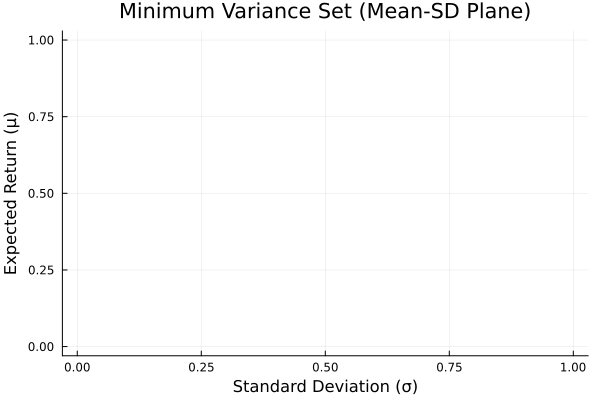

In [20]:
targets = -0.5:0.1:0.2
frontier_μ = Float64[]
frontier_σ = Float64[]
frontier_w = []

for target in targets
    model = Model(Ipopt.Optimizer)
    set_silent(model)

    @variable(model, 0 <= w[1:3] <= 1)
    @constraint(model, sum(w) == 1)
    @constraint(model, dot(w, μ) >= target)
    @objective(model, Min, w' * Σ * w)

    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        w_opt = value.(w)
        μ_opt = dot(w_opt, μ)
        σ_opt = sqrt(max(0.0, dot(w_opt, Σ * w_opt)))

        push!(frontier_μ, μ_opt)
        push!(frontier_σ, σ_opt)
        push!(frontier_w, round.(w_opt, digits=4))
        println("Target: ", target, ", Achieved μ: ", round(μ_opt, digits=3)) # Print achieved mu
    else
        push!(frontier_μ, NaN)
        push!(frontier_σ, NaN)
        push!(frontier_w, [NaN, NaN, NaN])
        println("Target: ", target, ", Optimization failed.") # Print when optimization fails
    end
end

println("\n5. Minimum Variance Frontier (μ* >= target):")
df = DataFrame(Target = targets, μ = round.(frontier_μ, digits=3), σ = round.(frontier_σ, digits=3), w1 = getindex.(frontier_w,1), w2 = getindex.(frontier_w,2), w3 = getindex.(frontier_w,3))
display(df)

# Plot
p = plot(
    frontier_σ, frontier_μ,
    xlabel = "Standard Deviation (σ)",
    ylabel = "Expected Return (μ)",
    title = "Minimum Variance Set (Mean-SD Plane)",
    legend = false,
    marker = :circle,
    color = :blue,
    linewidth = 2
)

# Annotate points
for i in 1:length(targets)
    if !isnan(frontier_σ[i])
        annotate!(frontier_σ[i], frontier_μ[i], text("$(targets[i])", :left, 8, :black))
    end
end

display(p)

## 6. Repeat Kelly with Ernest Odds = 5

Now: **odds = [1, 2, 5]**

In [21]:
odds_new = [1.0, 2.0, 5.0]

model6 = Model(Ipopt.Optimizer)
set_silent(model6)

@variable(model6, w[1:3] >= 0)
@constraint(model6, sum(w) == 1)
@NLobjective(model6, Max, sum(p[i] * log(1 + w[i] * odds_new[i]) for i in 1:3))

optimize!(model6)

w_kelly_er = value.(w)

println("6. Kelly Weights (Ernest odds = 5): ", round.(w_kelly_er, digits=4))

# Recalculate expected returns
E_R_new = p .* (odds_new .+ 1) .- 1
println("   New Expected Returns: ", round.(E_R_new, digits=3))

LoadError: BoundsError: attempt to access 1-element Vector{Plots.Subplot} at index [2]

In [22]:
odds_new = [1.0, 2.0, 5.0]
p = [0.6, 0.3, 0.1] # Assuming p is the same as before

model6 = Model(Ipopt.Optimizer)
set_silent(model6)

@variable(model6, w[1:3] >= 0)
@constraint(model6, sum(w) == 1)
@NLobjective(model6, Max, sum(p[i] * log(1 + w[i] * odds_new[i]) for i in 1:3))

optimize!(model6)

w_kelly_er = value.(w)

println("6. Kelly Weights (Ernest odds = 5): ", round.(w_kelly_er, digits=4))

# Recalculate expected returns
E_R_new = p .* (odds_new .+ 1) .- 1
println("   New Expected Returns: ", round.(E_R_new, digits=3))

6. Kelly Weights (Ernest odds = 5): [0.62, 0.31, 0.07]
   New Expected Returns: [0.2, -0.1, -0.4]
